In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

We choose the S&P500 stocks as our stock pool. After seleting the stocks according to ..., the size of our stock pool is 496. For this chapter, we did
- Data loading and preprocessing
- Outlier handling
- ADF and KPSS tests
- Volatility analysis
- Seasonality analysis

# 1. Load data

In [3]:
csv_files = glob.glob("../data/raw/*.csv")
dfs = {}
for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file, parse_dates=["trade_date"] )
    df.set_index("trade_date", inplace=True)

    df = df[~df.index.duplicated(keep='first')]
    num_cols = ["open", "high", "low", "close", "vol", "pct_change", "vwap"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    df['return'] = df['pct_change'] / 100.0
    dfs[symbol] = df

In [4]:
len(list(dfs.keys()))


496


We started by reading multiple `.csv` files from the raw data folder. Each file corresponds to a stock and contains columns such as `trade_date`, `open`, `high`, `low`, `close`, `vol`, `pct_change`, and `vwap`. The preprocessing included:

- Parsing `trade_date` as datetime and setting it as the index.
- Converting numerical columns to appropriate types and handling errors.
- Sorting by date and filling missing values using forward and backward fill.
- Computing daily returns using:

$$
\text{return}_t = \frac{\text{pct\_change}_t}{100}
$$

# 2. Comparison of all stocks' returns on time series

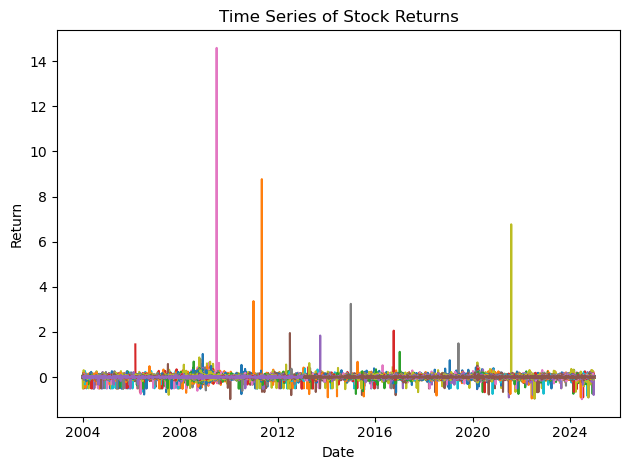

In [5]:

returns_df = pd.DataFrame({sym: df['return'] for sym, df in dfs.items()})

plt.figure()
for sym in returns_df.columns:
    plt.plot(returns_df.index, returns_df[sym], label=sym)
plt.title("Time Series of Stock Returns")
plt.xlabel("Date")
plt.ylabel("Return")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

We aggregated the return series of all individual stocks into a single DataFrame and visualized their time series. This visualization allowed us to:

- Observe general trends in returns over time
- Identify common patterns of volatility
- Detect potential structural breaks or anomalies in the market

The results revealed that, over the period from 2003-12-31 to 2024-12-31, most stock returns fluctuated within the range of -15% to 15%. However, we identified certain extreme values likely caused by corporate actions such as stock splits, which introduced distortions into the return data. To ensure the integrity of our analysis, we proceeded with outlier handling to mitigate the impact of these anomalies.



# 3. Outlier handling on combined returns_df

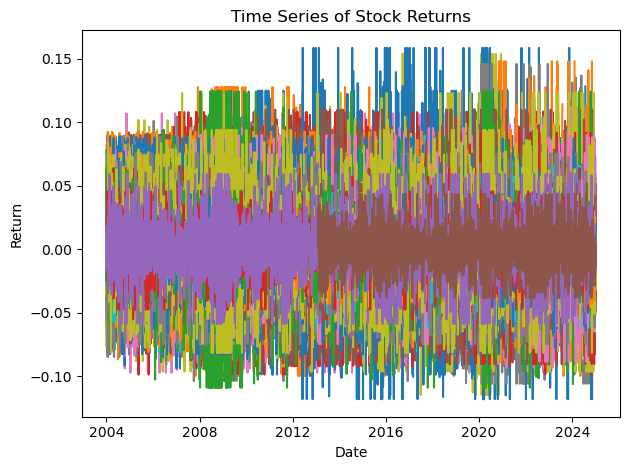

In [6]:

lower = returns_df.quantile(0.01)
upper = returns_df.quantile(0.99)
returns_df = returns_df.clip(lower=lower, upper=upper, axis=1)
plt.figure()
for sym in returns_df.columns:
    plt.plot(returns_df.index, returns_df[sym], label=sym)
plt.title("Time Series of Stock Returns")
plt.xlabel("Date")
plt.ylabel("Return")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

To mitigate the influence of extreme values, we clipped the returns at the 1st and 99th percentiles:

$$
r_t^{\text{clipped}} = 
\begin{cases}
q_{0.01}, & \text{if } r_t < q_{0.01} \\
r_t, & \text{if } q_{0.01} \leq r_t \leq q_{0.99} \\
q_{0.99}, & \text{if } r_t > q_{0.99}
\end{cases}
$$

After transformation, the new plot shows that all the returns are now clipped between -13% and 17%. This transformation reduces the impact of outliers and enhances the robustness of subsequent statistical analysis.



# 4. Unit root testing (ADF and KPSS)

In [7]:
unit_root = []
for sym, df in dfs.items():
    series = df['return'].dropna()
    # ADF
    adf_res = adfuller(series)
    # KPSS
    kpss_res = kpss(series, nlags='auto')
    unit_root.append({
        'symbol': sym,
        'adf_stat': adf_res[0],
        'adf_pvalue': adf_res[1],
        'kpss_stat': kpss_res[0],
        'kpss_pvalue': kpss_res[1]
    })
unit_root_df = pd.DataFrame(unit_root).set_index('symbol')
unit_root_df['stationary'] = np.where((unit_root_df['adf_pvalue'] < 0.05) & (unit_root_df['kpss_pvalue'] > 0.05), True, False)

print("=== Unit Root Test Results ===")
print(unit_root_df)



C:\Users\tyyzl\AppData\Local\Temp\ipykernel_5896\3883615200.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')
C:\Users\tyyzl\AppData\Local\Temp\ipykernel_5896\3883615200.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')
C:\Users\tyyzl\AppData\Local\Temp\ipykernel_5896\3883615200.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')
C:\Users\tyyzl\AppData\Local\Temp\ipykernel_5896\3883615200.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The ac

=== Unit Root Test Results ===
         adf_stat    adf_pvalue  kpss_stat  kpss_pvalue  stationary
symbol                                                             
A      -17.659883  3.686393e-30   0.039479          0.1        True
AAPL   -17.732185  3.431050e-30   0.270045          0.1        True
ABBV   -13.765566  9.899805e-26   0.034067          0.1        True
ABNB    -8.557287  8.888481e-14   0.033454          0.1        True
ABT    -31.886393  0.000000e+00   0.098426          0.1        True
...           ...           ...        ...          ...         ...
XYL    -19.042021  0.000000e+00   0.056580          0.1        True
YUM    -16.565890  1.889098e-29   0.023084          0.1        True
ZBH    -26.126425  0.000000e+00   0.043915          0.1        True
ZBRA   -24.651258  0.000000e+00   0.321215          0.1        True
ZTS    -15.311621  4.178907e-28   0.154204          0.1        True

[496 rows x 5 columns]


C:\Users\tyyzl\AppData\Local\Temp\ipykernel_5896\3883615200.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')


In [8]:
unit_root_df['stationary'] = np.where((unit_root_df['adf_pvalue'] < 0.05) & (unit_root_df['kpss_pvalue'] > 0.05), 1, 0)

print("=== Unit Root Test Results ===")
print(unit_root_df)

=== Unit Root Test Results ===
         adf_stat    adf_pvalue  kpss_stat  kpss_pvalue  stationary
symbol                                                             
A      -17.659883  3.686393e-30   0.039479          0.1           1
AAPL   -17.732185  3.431050e-30   0.270045          0.1           1
ABBV   -13.765566  9.899805e-26   0.034067          0.1           1
ABNB    -8.557287  8.888481e-14   0.033454          0.1           1
ABT    -31.886393  0.000000e+00   0.098426          0.1           1
...           ...           ...        ...          ...         ...
XYL    -19.042021  0.000000e+00   0.056580          0.1           1
YUM    -16.565890  1.889098e-29   0.023084          0.1           1
ZBH    -26.126425  0.000000e+00   0.043915          0.1           1
ZBRA   -24.651258  0.000000e+00   0.321215          0.1           1
ZTS    -15.311621  4.178907e-28   0.154204          0.1           1

[496 rows x 5 columns]


In [9]:
unit_root_df.describe()

,adf_stat,adf_pvalue,kpss_stat,kpss_pvalue,stationary
count,496.000000,4.960000e+02,496.000000,496.000000,496.000000
mean,-26.320974,2.292584e-10,0.115595,0.097138,0.967742
std,17.470575,5.105823e-09,0.124072,0.013534,0.176863
min,-77.920836,0.000000e+00,0.013336,0.010000,0.000000
25%,-28.653491,0.000000e+00,0.043893,0.100000,1.000000
50%,-18.882699,0.000000e+00,0.072761,0.100000,1.000000
75%,-14.572180,4.614252e-27,0.137682,0.100000,1.000000
max,-6.073311,1.137121e-07,1.011941,0.100000,1.000000


To assess the stationarity of stock return series, we performed the **Augmented Dickey-Fuller (ADF)** and **KPSS** tests across all 496 stocks. 

### Augmented Dickey-Fuller (ADF) Test

- Null hypothesis \( H_0 \): The series has a unit root (non-stationary)
- If p-value < 0.05, we reject \( H_0 \), suggesting stationarity.

### KPSS Test

- Null hypothesis $ H_0 $: The series is stationary
- If p-value > 0.05, we fail to reject $ H_0 $, suggesting stationarity.

### Decision Rule

A series is considered stationary only if:

- ADF test rejects $ H_0 $ (p < 0.05), and
- KPSS test fails to reject $ H_0 $ (p > 0.05)

This dual-criteria approach ensures robustness in stationarity conclusions.

The following summarizes the statistical properties of the test results:


| Metric         | ADF Statistic         | ADF p-value          | KPSS Statistic       | KPSS p-value         | Stationary (True = 1) |
|----------------|------------------------|------------------------|------------------------|------------------------|------------------------|
| **Count**      | 496                    | 496                    | 496                    | 496                    | 496                    |
| **Mean**       | -26.32                 | $2.29 \times 10^{-10}$ | 0.116                  | 0.097                  | 0.968                  |
| **Min**        | -77.92                 | 0.0                    | 0.013                  | 0.010                  | 0                      |
| **Max**        | -6.07                  | $1.14 \times 10^{-7}$ | 1.012                  | 0.100                  | 1                      |

### Interpretation

- The **ADF test** statistic has a strongly negative mean of -26.32 and nearly all p-values are effectively 0, indicating strong evidence to reject the null hypothesis of a unit root. This suggests the return series are stationary under the ADF test.
  
- The **KPSS test** statistic has a mean of 0.116, with the maximum value slightly above 1. Most of the p-values are exactly 0.1 (the upper bound reported by the test), suggesting that the null hypothesis of stationarity is not rejected in most cases.

- The final boolean column `stationary` applies a dual-criterion: 
  - ADF p-value < 0.05 (rejects non-stationarity)
  - KPSS p-value > 0.05 (fails to reject stationarity)

  Based on this rule, about 96.8% of the return series are confirmed to be stationary.

These results confirm that the majority of stock return series in our dataset can be treated as stationary, validating their suitability for further time series modeling and statistical analysis.


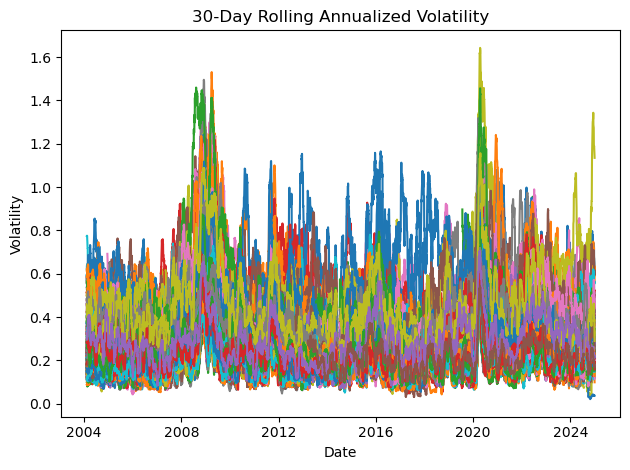

In [49]:
# 5. Volatility analysis: rolling standard deviation
window = 30  # days
vol_df = returns_df.rolling(window).std() * np.sqrt(252)  # annualized volatility

plt.figure()
for sym in vol_df.columns:
    plt.plot(vol_df.index, vol_df[sym], label=sym)
plt.title(f"{window}-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
#plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


## 6. Seasonality Analysis: Seasonal Decomposition of Return Series for Each Stock

<Figure size 1200x800 with 0 Axes>

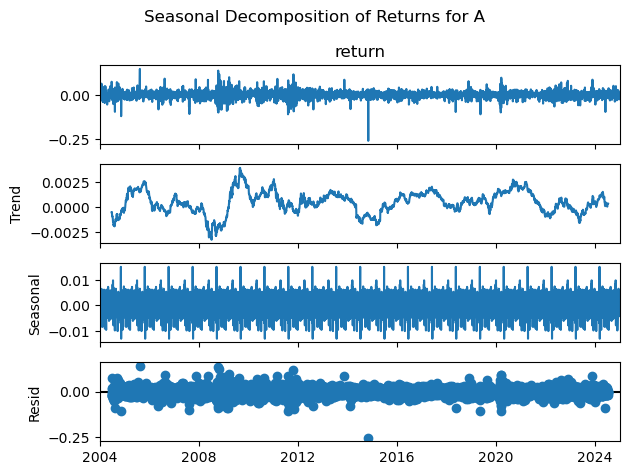

<Figure size 1200x800 with 0 Axes>

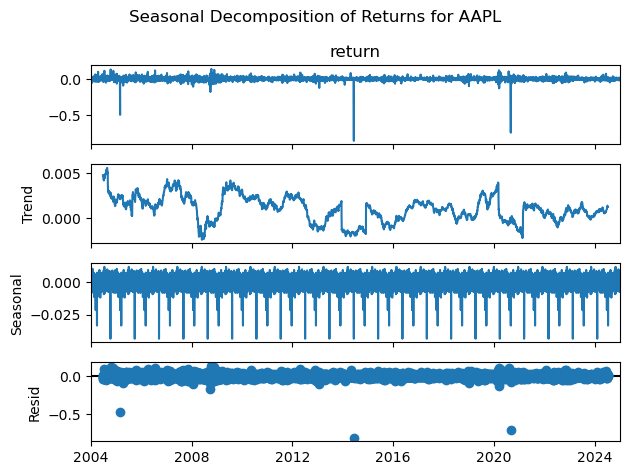

<Figure size 1200x800 with 0 Axes>

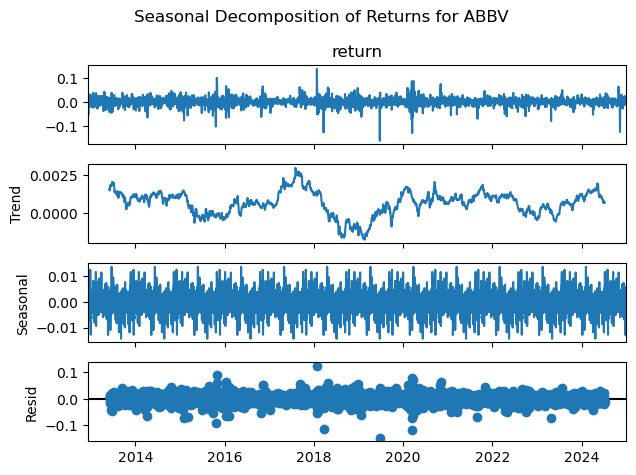

<Figure size 1200x800 with 0 Axes>

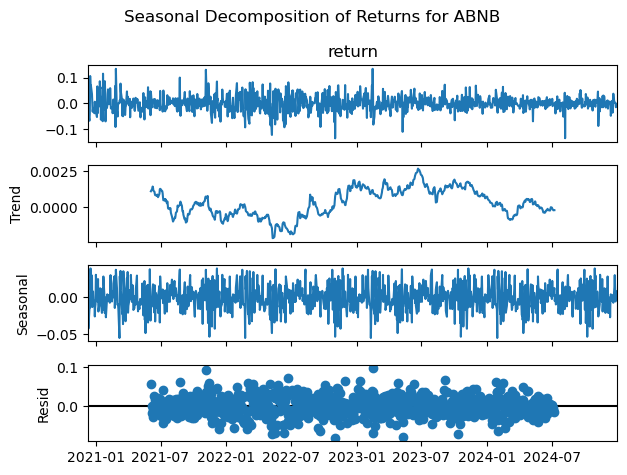

<Figure size 1200x800 with 0 Axes>

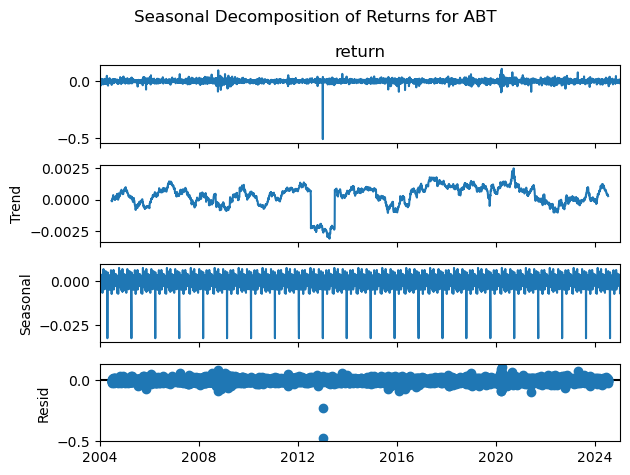

<Figure size 1200x800 with 0 Axes>

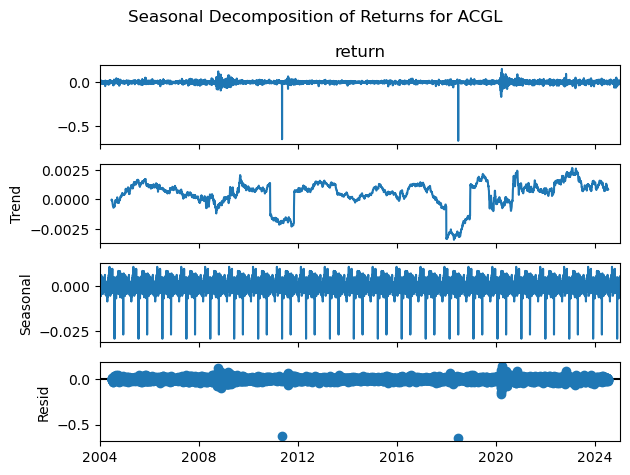

<Figure size 1200x800 with 0 Axes>

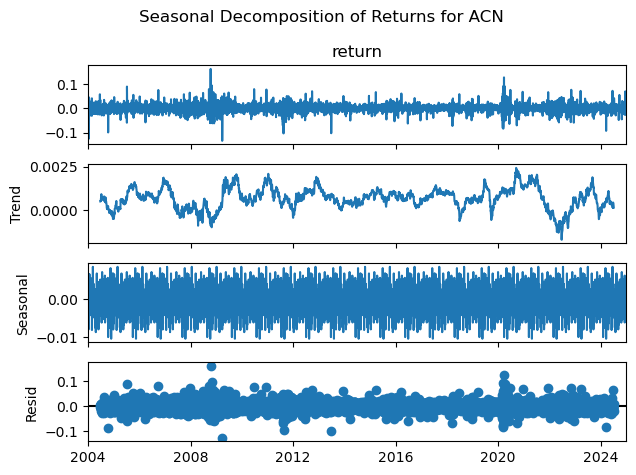

<Figure size 1200x800 with 0 Axes>

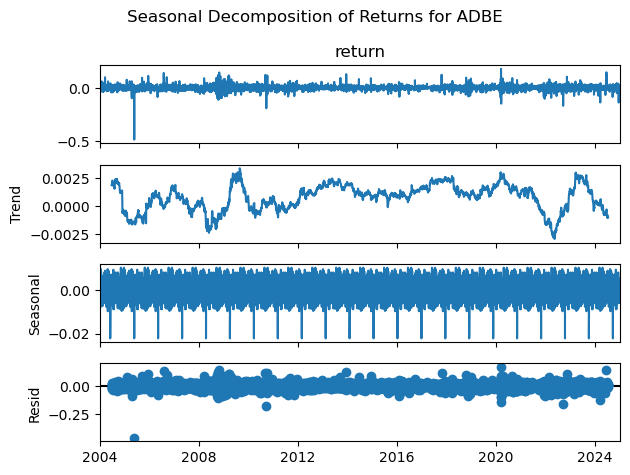

<Figure size 1200x800 with 0 Axes>

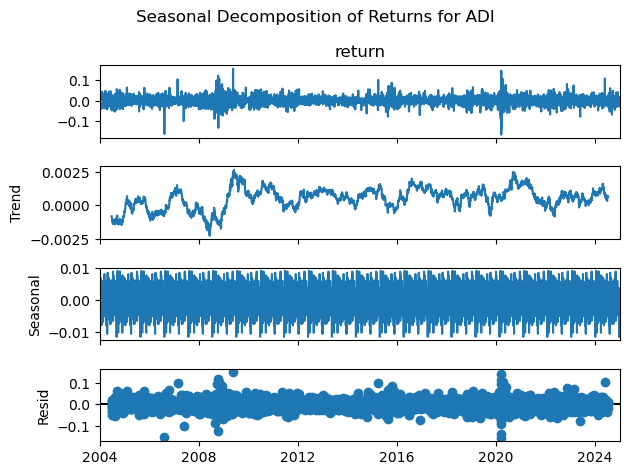

<Figure size 1200x800 with 0 Axes>

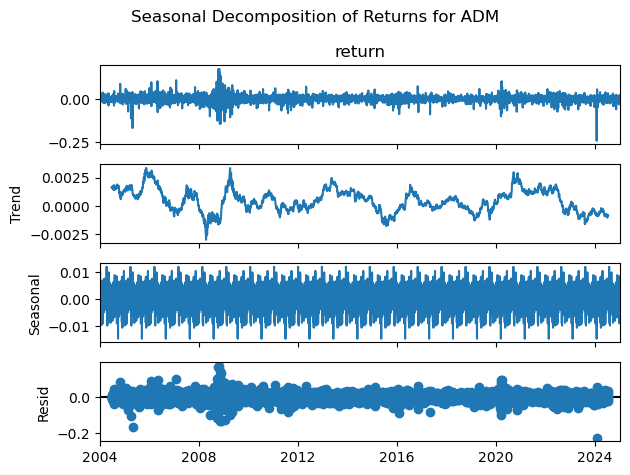

Not enough data for CPAY for seasonal decomposition.
Not enough data for DAY for seasonal decomposition.
Not enough data for EG for seasonal decomposition.


In [10]:
seasonal_results = {}
i = 0
for sym, df in dfs.items():
    # use daily return series
    series = df['return'].asfreq('B')  # convert to business-day frequency
    series = series.interpolate()      # fill missing values
    
    # Skip if not enough data for a reliable seasonal decomposition
    if len(series) < 504:
        print(f"Not enough data for {sym} for seasonal decomposition.")
        continue
    
    # Decompose with a period of 252 trading days (~1 year)
    decomposition = seasonal_decompose(series, model='additive', period=252)
    seasonal_results[sym] = decomposition
    
    # Optional: plot results
    if i < 10:
        plt.figure(figsize=(12, 8))
        fig = decomposition.plot()
        fig.suptitle(f"Seasonal Decomposition of Returns for {sym}")
        plt.tight_layout()
        plt.show()
        i += 1



In this section, we analyzed the seasonal patterns in daily stock returns using additive time series decomposition. Unlike prices, returns are generally stationary, making them more appropriate for identifying cyclical patterns.

The additive model used for decomposition is:

$$
r_t = T_t + S_t + R_t
$$

Where:
- $ r_t $: Observed return at time $ t $
- $ T_t $: Trend component
- $ S_t $: Seasonal component
- $ R_t $: Residual (noise)

### Procedure

- For each stock, we extracted the return series and converted it to business-day frequency:

$$
\text{series} = \text{df['return'].asfreq('B')}
$$

- Missing values were interpolated linearly to ensure continuity.
- We excluded stocks with fewer than 504 business-day observations (approximately 2 years) to ensure robust decomposition.
- Seasonal decomposition was applied using a period of 252, which corresponds to the typical number of trading days in a year:

$$
\text{decomposition} = \text{seasonal\_decompose}(r_t, \text{model='additive'}, \text{period}=252)
$$

The resulting components allow us to identify:
- Long-term movements in average return (trend)
- Predictable seasonal cycles such as quarterly effects (seasonality)
- Short-term noise or shocks (residual)



### A (Agilent Technologies)

- **Trend**: Displays a relatively smooth and stable long-term pattern with mild fluctuations.
- **Seasonality**: Exhibits minor but regular intra-year patterns, suggesting weak seasonal effects.
- **Residual**: Shows limited volatility clustering with a few irregular spikes, likely due to idiosyncratic news or market events.

Stock A has stable return dynamics with low seasonal influence. It is a good candidate for models assuming stationarity and low noise.


### AAPL (Apple Inc.)

- **Trend**: Demonstrates clear long-term growth and volatility changes over time, particularly around known product cycles and macro events.
- **Seasonality**: Strong and sharp recurring seasonal dips and spikes, likely tied to earnings reports, product releases, and holiday seasons.
- **Residual**: Contains large outliers and elevated variance in periods like 2008 and 2020, indicating sensitivity to systemic shocks.

AAPL’s return series reveals pronounced seasonality and higher volatility. This stock may benefit from models that incorporate time-varying volatility and seasonal components.


### ABBV (AbbVie Inc.)

- **Trend**: Reflects medium-term fluctuations typical of a large-cap pharmaceutical firm.
- **Seasonality**: Contains regular oscillations with moderate amplitude, possibly tied to R&D cycles, drug launches, or quarterly earnings.
- **Residual**: Residuals are mostly centered and stable, with occasional volatility bursts.

ABBV balances trend and seasonality well, making it a suitable candidate for seasonal ARIMA or other hybrid models with trend-seasonal structure.

These decompositions show the diversity across sectors and firms. Incorporating seasonality and time-varying trends into forecasting models can significantly improve performance, especially for firms with strong cyclical return behavior. 

(However, we haven't consider seasonality into our model so far. could write it in future improvement.)

In [ ]:
# # 7. Seasonal strength metric
# # Seasonal strength = var(seasonal) / (var(seasonal) + var(resid))
# strength = {}
# for sym, dec in seasonal_results.items():
#     var_seas = np.nanvar(dec.seasonal)
#     var_resid = np.nanvar(dec.resid)
#     strength[sym] = var_seas / (var_seas + var_resid)
# strength_df = pd.Series(strength, name='seasonal_strength')
# print("=== Seasonal Strength by Symbol ===")
# print(strength_df)


=== Seasonal Strength by Symbol ===
A       0.060462
AAPL    0.048096
ABBV    0.119751
ABNB    0.300969
ABT     0.058908
          ...   
XYL     0.075545
YUM     0.045945
ZBH     0.022118
ZBRA    0.026934
ZTS     0.071726
Name: seasonal_strength, Length: 493, dtype: float64


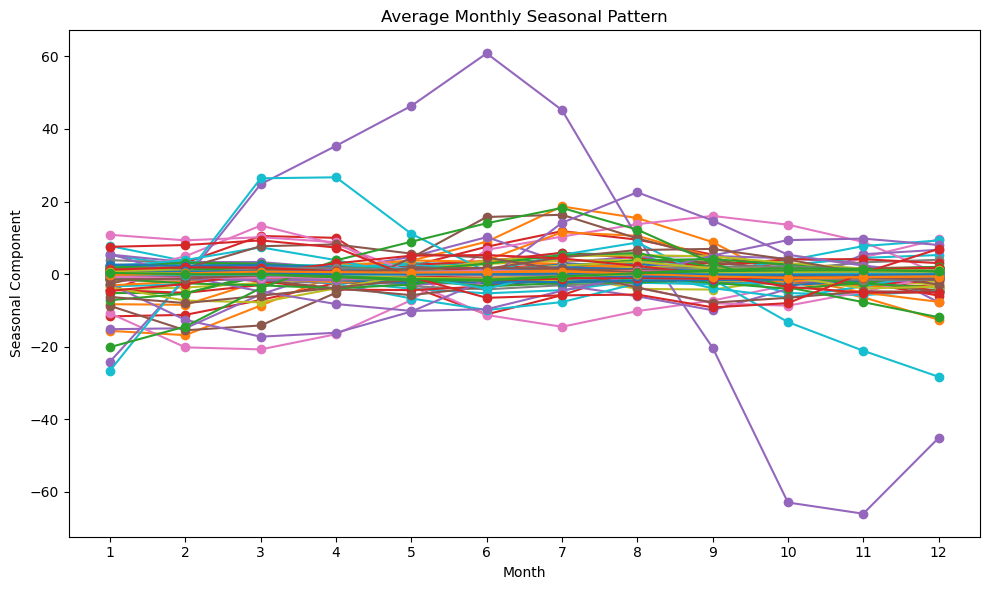

In [ ]:
# # 8. Average monthly seasonal pattern
# # Align all seasonal series and compute mean by month-of-year
# all_seasonal = pd.DataFrame({sym: dec.seasonal for sym, dec in seasonal_results.items()})
# all_seasonal.index = pd.DatetimeIndex(all_seasonal.index)
# monthly_pattern = all_seasonal.groupby(all_seasonal.index.month).mean()

# plt.figure(figsize=(10,6))
# for sym in monthly_pattern.columns:
#     plt.plot(monthly_pattern.index, monthly_pattern[sym], marker='o', label=sym)
# plt.title('Average Monthly Seasonal Pattern')
# plt.xlabel('Month')
# plt.ylabel('Seasonal Component')
# plt.xticks(range(1,13))
# #plt.legend(loc='upper left', bbox_to_anchor=(1,1))
# plt.tight_layout()
# plt.show()